In [3]:
import time
import numpy as np

from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
from brainflow.data_filter import DataFilter, WindowOperations, DetrendOperations


In [4]:
def calculate_alpha_beta_ratio(port='COM4'):
    # Step 2: Initialize the board information
    boardID = BoardIds.CYTON_BOARD  # Assuming CYTON_BOARD is the board type
    boardDescr = BoardShim.get_board_descr(boardID)
    sampleRate = int(boardDescr['sampling_rate'])  # Extract and convert sampling rate to integer

    # Step 3: Set the board parameters
    board_params = BrainFlowInputParams()
    board_params.serial_port = port

    # Step 4: Create the board object
    board = BoardShim(boardID, board_params)

    # Step 5: Prepare the board session and start the stream
    board.prepare_session()  # Prepare the board for data streaming
    board.start_stream()  # Start data streaming

    # Step 6: Calculate the nearest power of two for spectral power estimation
    nearest_power_of_2 = DataFilter.get_nearest_power_of_two(sampleRate)

    # Step 7: Acquire data
    time.sleep(2)  # Pause for 2 seconds to accumulate data
    data = board.get_board_data()  # Retrieve data from the board

    # Step 8: Extract the EEG channel information
    eeg_channels = boardDescr['eeg_channels']  # Extract EEG channel information

    # Step 9: Initialize the alpha-beta ratio array
    alpha_beta_ratio = np.zeros(len(eeg_channels))  # Create an array for alpha-beta ratios

    # Step 10: Process each EEG channel
    for count, channel in enumerate(eeg_channels):
        # a. Apply detrending to the channel data
        DataFilter.detrend(data[channel], DetrendOperations.LINEAR.value)

        # b. Calculate the power spectrum using Welch's method
        psd = DataFilter.get_psd_welch(
            data[channel],
            nearest_power_of_2,
            nearest_power_of_2 // 2,
            sampleRate,
            WindowOperations.HANNING.value
        )

        # c. Extract alpha and beta band power
        alpha_power = DataFilter.get_band_power(psd, 7.0, 13.0)
        beta_power = DataFilter.get_band_power(psd, 14.0, 30.0)

        # d. Compute alpha-beta ratio
        alpha_beta_ratio[count] = beta_power / alpha_power if alpha_power != 0 else 0

    # Step 11: Stop and release the session
    if board.is_prepared():
        board.release_session()

    # Step 12: Return the mean alpha-beta ratio
    return np.mean(alpha_beta_ratio)

In [5]:
# Run as standalone
if __name__ == "__main__":
    try:
        while True:
            ratio = calculate_alpha_beta_ratio()
            print("alpha/beta ratio:", ratio)
    except KeyboardInterrupt:
        quit()

BrainFlowError: BOARD_WRITE_ERROR:4 unable to prepare streaming session

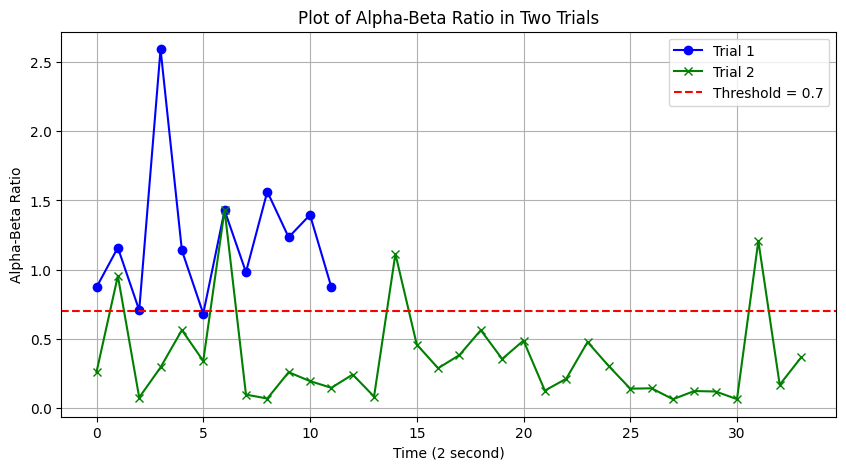

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the arrays
array1 = np.array([
    0.8730716694587185, 1.159414253184233, 0.7070128708146493, 2.592023820572029,
    1.1389121601844427, 0.6827929906378345, 1.4284994923002634, 0.982325842279825,
    1.5636810956024525, 1.234055760036882, 1.3960382697571376, 0.8741384859129144
])
array2 = np.array([
    0.2606171266000487, 0.9555159251568611, 0.07703311357037709, 0.2948826732083205,
    0.5642508260943401, 0.34082395397928733, 1.4317175507765723, 0.09825012689008149,
    0.0696026037208356, 0.26004915814198354, 0.19561788927437018, 0.14726859526071773,
    0.24312071737495722, 0.08373773089287327, 1.113580952440191, 0.45977757622798165,
    0.2886816282663838, 0.38382772365810913, 0.5635432886990124, 0.35555417443695314,
    0.4883743260034386, 0.12710588125990224, 0.21254342095285325, 0.47781185707398144,
    0.302975636291273, 0.14101390348177245, 0.14368573742669083, 0.0647898484400741,
    0.12388516083576195, 0.12046985197955447, 0.06537952851814106, 1.2082909507015112,
    0.16917484501614666, 0.36620987082790923
])

# Create time arrays
time1 = np.arange(len(array1))
time2 = np.arange(len(array2))

# Plot the arrays
plt.figure(figsize=(10, 5))

# Plot array1 where it has values
plt.plot(time1, array1, label="Trial 1", color='blue', marker='o')

# Plot array2 entirely
plt.plot(time2, array2, label="Trial 2", color='green', marker='x')

# Add a horizontal dashed threshold line at 0.7
plt.axhline(y=0.7, color='red', linestyle='--', label="Threshold = 0.7")

# Add labels, legend, and grid
plt.xlabel("Time (2 second)")
plt.ylabel("Alpha-Beta Ratio")
plt.title("Plot of Alpha-Beta Ratio in Two Trials")
plt.legend()
plt.grid(True)
plt.show()


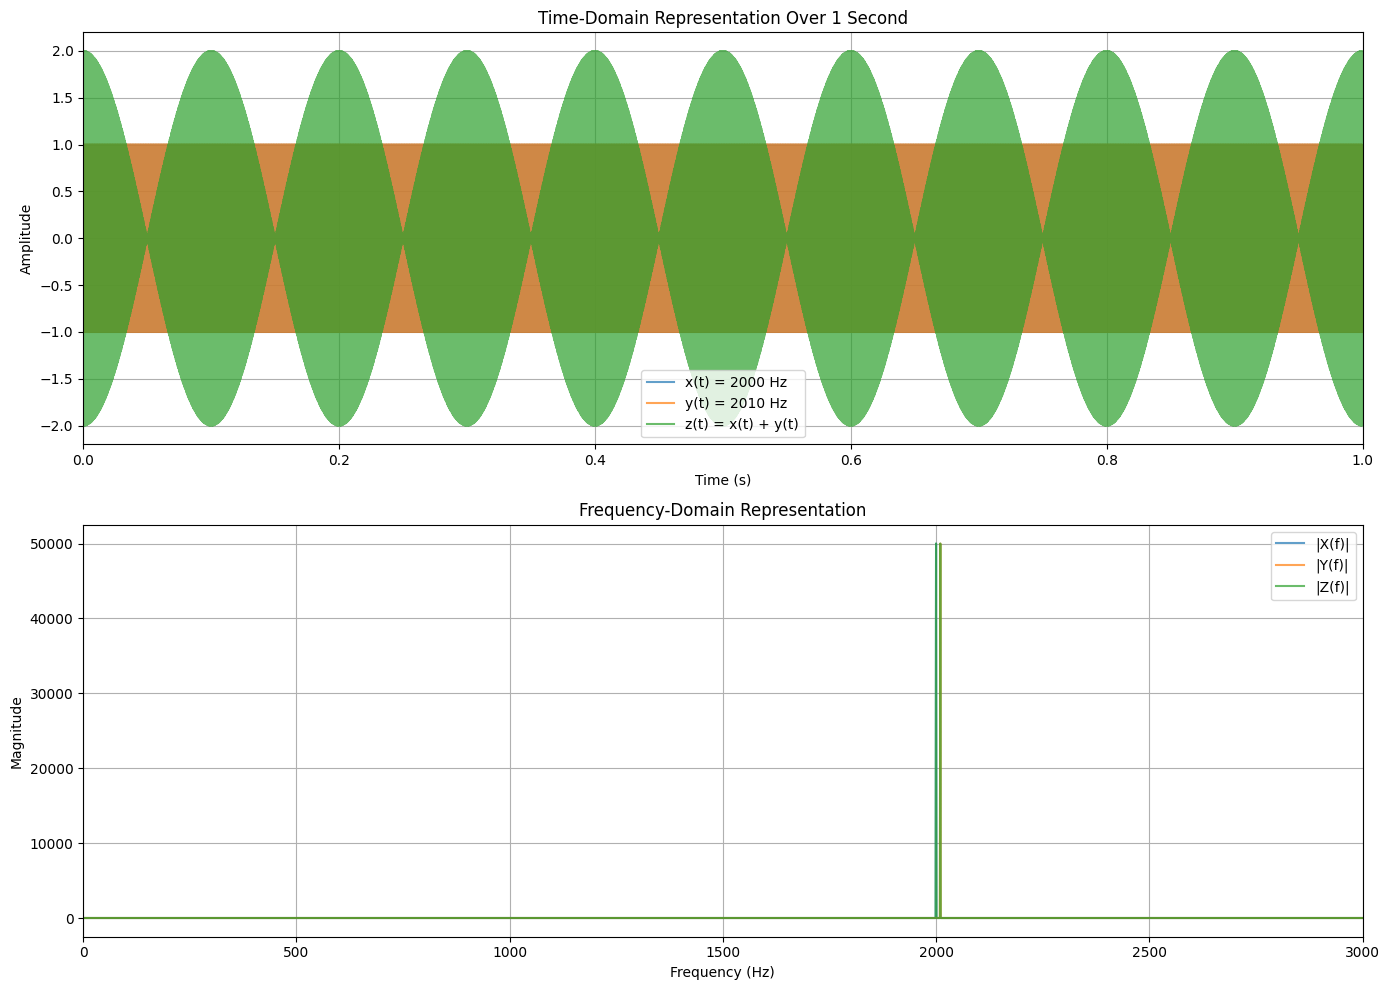

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
fs = 100000  # Sampling frequency in Hz
t = np.arange(0, 1, 1/fs)  # Time vector for 1 second

# Sinusoidal signals
f_x = 2000  # Frequency of x in Hz
f_y = 2010  # Frequency of y in Hz
x = np.sin(2 * np.pi * f_x * t)  # Sinusoidal wave x
y = np.sin(2 * np.pi * f_y * t)  # Sinusoidal wave y
z = x + y  # Sum of x and y

# Compute Fourier Transform
freqs = np.fft.fftfreq(len(t), d=1/fs)  # Frequency vector
X = np.fft.fft(x)  # Fourier Transform of x
Y = np.fft.fft(y)  # Fourier Transform of y
Z = np.fft.fft(z)  # Fourier Transform of z

# Get positive frequency components
positive_freqs = freqs[freqs >= 0]
X_magnitude = np.abs(X[freqs >= 0])
Y_magnitude = np.abs(Y[freqs >= 0])
Z_magnitude = np.abs(Z[freqs >= 0])

# Plot time series
plt.figure(figsize=(14, 10))

# Time-domain plot
plt.subplot(2, 1, 1)
plt.plot(t, x, label="x(t) = 2000 Hz", alpha=0.7)
plt.plot(t, y, label="y(t) = 2010 Hz", alpha=0.7)
plt.plot(t, z, label="z(t) = x(t) + y(t)", alpha=0.7)
plt.title("Time-Domain Representation Over 1 Second")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.xlim(0, 1)  # Display the full 1-second duration

# Frequency-domain plot
plt.subplot(2, 1, 2)
plt.plot(positive_freqs, X_magnitude, label="|X(f)|", alpha=0.7)
plt.plot(positive_freqs, Y_magnitude, label="|Y(f)|", alpha=0.7)
plt.plot(positive_freqs, Z_magnitude, label="|Z(f)|", alpha=0.7)
plt.title("Frequency-Domain Representation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.xlim(0, 3000)  # Focus on the region around the signal frequencies

plt.tight_layout()
plt.show()
